# Linear Regression on recent data

# 1. Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import r2_score, mean_squared_error
from datetime import timedelta

In [5]:
CSV_PATH = "btc_clean.cs.csv"
TIMESTAMP_COL = "Timestamp"
PRICE_COL = "Close"
WINDOW_YEARS = 4          # fit last N years to reflect current regime
USE_ROBUST = True         # Huber (robust) vs OLS
FIGSIZE_MAIN = (14, 8)
FIGSIZE_SMALL = (7, 6)

In [6]:
# importing bitcoin price data
df = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/btc_clean.csv', index_col = False)

In [7]:
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [8]:
# Ensure numeric seconds (your sample shows seconds)
ts = pd.to_numeric(df[TIMESTAMP_COL], errors="coerce")
# Heuristic: seconds vs ms
unit = "ms" if np.nanmedian(ts) > 1e12 else "s"
df["Date"] = pd.to_datetime(ts, unit=unit, errors="coerce")

In [10]:
# Basic cleaning
df = df.dropna(subset=["Date", PRICE_COL]).copy()
df = df[df[PRICE_COL] > 0]
df = df.sort_values("Date").drop_duplicates(subset=["Date"]).reset_index(drop=True)

if df.empty:
    raise ValueError("No valid rows after cleaning (check Timestamp/Close).")

print(f"Date range: {df['Date'].min().date()} → {df['Date'].max().date()} | n={len(df):,}")

Date range: 2012-01-01 → 2025-09-25 | n=7,222,717


In [11]:
# -------------------------
# Choose a recent window
# -------------------------
end_date = df["Date"].max()
start_date = end_date - pd.DateOffset(years=WINDOW_YEARS)
win = df[df["Date"].between(start_date, end_date)].copy()
if len(win) < 50:
    print("Window too small; falling back to full dataset.")
    win = df.copy()
else:
    print(f"Fitting on: {start_date.date()} → {end_date.date()} | n={len(win):,}")


Fitting on: 2021-09-25 → 2025-09-25 | n=2,102,681


In [12]:
# -------------------------
# Power-law transform
# price = a * t^b  <=>  log10(price) = log10(a) + b*log10(t)
# with t = days since window start (start at 1 to avoid log(0))
# -------------------------
t0 = win["Date"].min()
win["days"] = (win["Date"] - t0).dt.days + 1
win["log_days"] = np.log10(win["days"].astype(float))
win["log_price"] = np.log10(win[PRICE_COL].astype(float))

X = win[["log_days"]].values
y = win["log_price"].values

In [14]:
# -------------------------
# Fit model (robust by default)
# -------------------------
if USE_ROBUST:
    model = HuberRegressor(epsilon=1.35, alpha=0.0)
else:
    model = LinearRegression()

model.fit(X, y)
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
a = 10 ** model.intercept_
b = float(model.coef_.ravel()[0])

print("\n================ POWER LAW (log10) ================")
print(f"log10(price) = {model.intercept_:.6f} + {b:.6f} * log10(days)")
print(f"Price = {a:.6f} × days^{b:.6f}")
print(f"R² = {r2:.4f} | RMSE(log10) = {rmse:.4f}")
if r2 > 0.85:
    print("✓ Strong power-law fit (within chosen window)")
elif r2 > 0.70:
    print("~ Moderate power-law fit (within chosen window)")
else:
    print("✗ Weak power-law fit (within chosen window)")



================ POWER LAW (log10) ================
log10(price) = 3.869492 + 0.286256 * log10(days)
Price = 7404.437885 × days^0.286256
R² = 0.1211 | RMSE(log10) = 0.2363
✗ Weak power-law fit (within chosen window)


In [15]:
# -------------------------
# Future projection (very rough)
# -------------------------
last_date = df["Date"].max()
horizon = 365
future_dates = pd.date_range(last_date + timedelta(days=1), periods=horizon, freq="D")

In [17]:
# IMPORTANT: keep t referenced to t0 (window start)
future_t = (future_dates - t0).days + 1
future_log_days = np.log10(future_t).reshape(-1, 1)
future_log_price = model.predict(future_log_days)
future_price = 10 ** future_log_price
pred_1y = float(future_price[-1])

print("\nFuture Prediction (naive power-law, 1y from last data point)")
print(f"Predicted price in ~1 year: ${pred_1y:,.2f}")
print("WARNING: crude extrapolation; BTC regimes change, so use with caution.\n")

AttributeError: 'Index' object has no attribute 'reshape'

In [18]:
# -------------------------
# Build fitted curve for full plot
# -------------------------
plot = df.copy()
plot["t_since_t0"] = (plot["Date"] - t0).dt.days + 1
plot = plot[plot["t_since_t0"] > 0]
plot["fitted"] = a * (plot["t_since_t0"].astype(float) ** b)

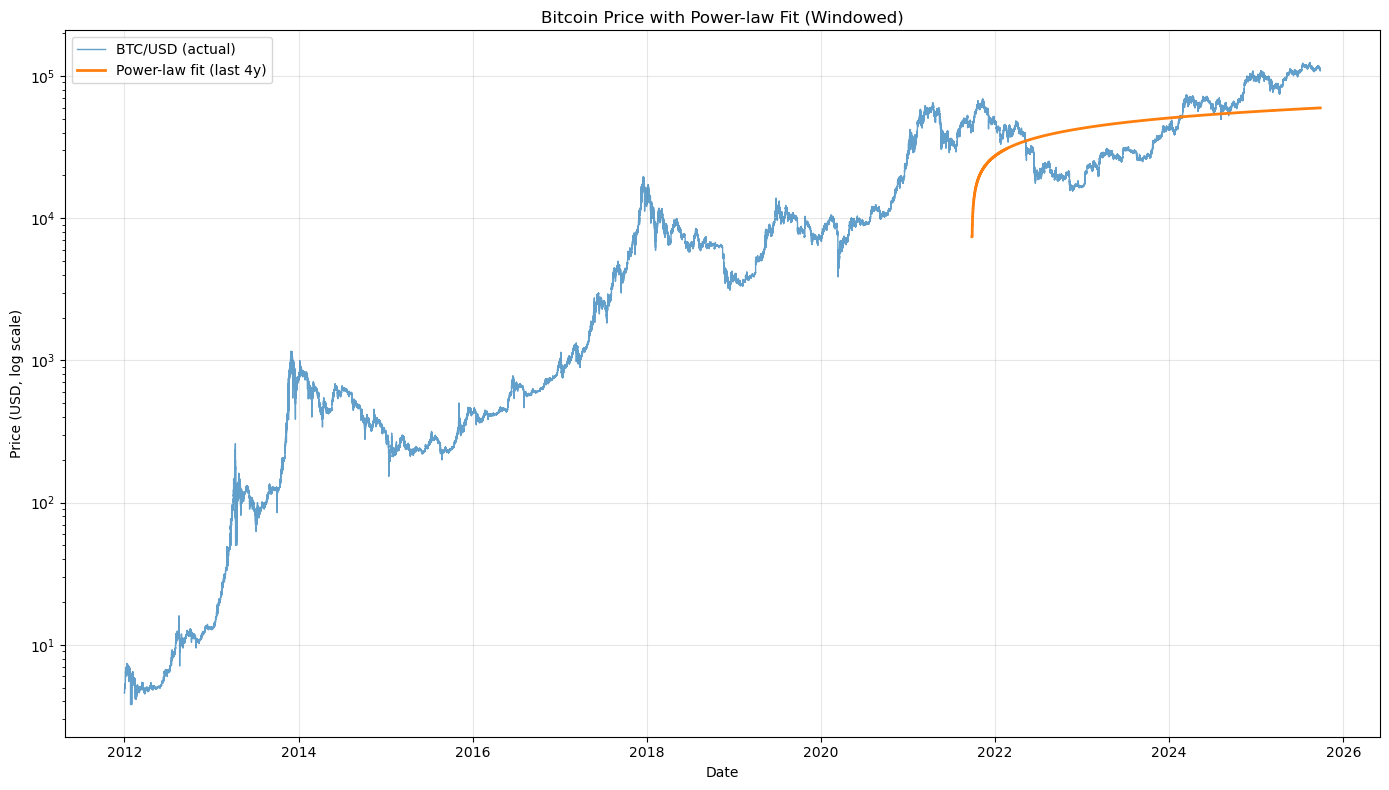

In [19]:
# -------------------------
# Plot 1: BTC price with power-law fit (log y)
# -------------------------
plt.figure(figsize=FIGSIZE_MAIN)
plt.plot(df["Date"], df[PRICE_COL], linewidth=1, alpha=0.7, label="BTC/USD (actual)")
plt.plot(plot["Date"], plot["fitted"], linewidth=2, label=f"Power-law fit (last {WINDOW_YEARS}y)")
plt.yscale("log")
plt.xlabel("Date")
plt.ylabel("Price (USD, log scale)")
plt.title("Bitcoin Price with Power-law Fit (Windowed)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

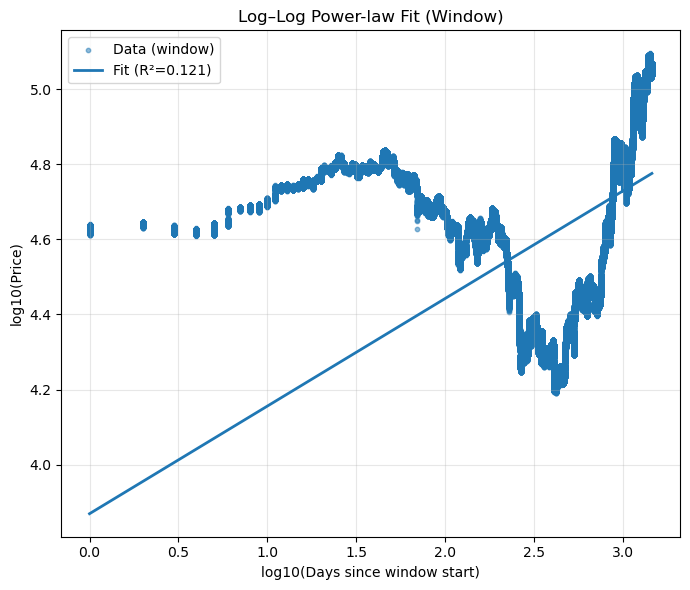

In [20]:
# -------------------------
# Plot 2: Log–log regression view (window only)
# -------------------------
plt.figure(figsize=FIGSIZE_SMALL)
plt.scatter(win["log_days"], win["log_price"], s=10, alpha=0.5, label="Data (window)")
xx = np.linspace(win["log_days"].min(), win["log_days"].max(), 200).reshape(-1, 1)
yy = model.predict(xx)
plt.plot(xx, yy, linewidth=2, label=f"Fit (R²={r2:.3f})")
plt.xlabel("log10(Days since window start)")
plt.ylabel("log10(Price)")
plt.title("Log–Log Power-law Fit (Window)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

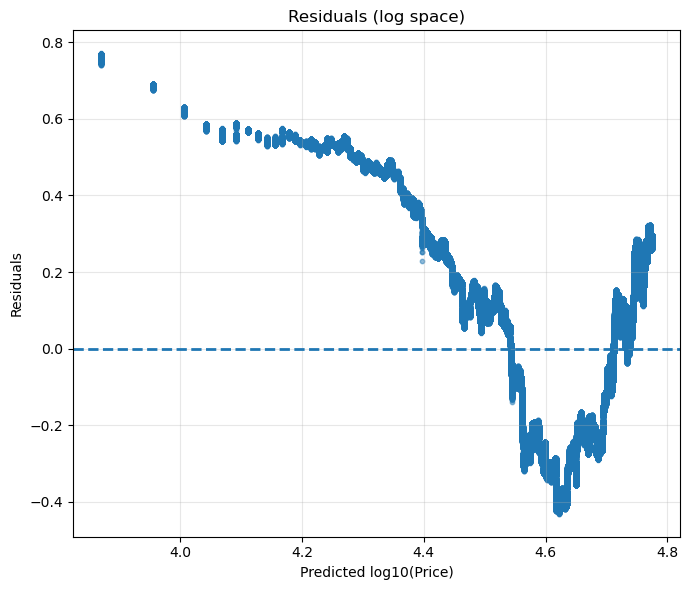

In [21]:
# -------------------------
# Plot 3: Residuals (log space)
# -------------------------
residuals = y - y_pred
plt.figure(figsize=FIGSIZE_SMALL)
plt.scatter(y_pred, residuals, s=10, alpha=0.5)
plt.axhline(0, linestyle="--", linewidth=2)
plt.xlabel("Predicted log10(Price)")
plt.ylabel("Residuals")
plt.title("Residuals (log space)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()